## VAE

Import required packages

In [ ]:
import torch
from tqdm import tqdm
from torch import nn, optim
from model import VariationalAutoEncoder  # Assuming you have a VAE model defined in 'model.py'
from torch.utils.data import TensorDataset, DataLoader
import h5py
import pandas as pd
import numpy as np
import scipy.io
from torch.optim import lr_scheduler
from deeper_model import DeepVariationalAutoEncoder

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 100 epochs"""
    NEW_LR_RATE = LR_RATE * (0.75 ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = NEW_LR_RATE

Configuration

In [46]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 1000
Z_DIM = 2
NUM_EPOCHS = 20000
BATCH_SIZE = 256 # Adjusted batch size
LR_RATE = 2e-4

# Assuming you have a PyTorch model called VariationalAutoEncoder defined in 'model.py'
model = VariationalAutoEncoder(input_dim=INPUT_DIM, h_dim=H_DIM, z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
#optimizer = optim.Adagrad(model.parameters(), lr=LR_RATE)
#loss_fn = nn.BCELoss(reduction="sum")  # You might want to use a different loss function
#loss_fn = nn.L1Loss(reduction="sum")
loss_fn = nn.MSELoss(reduction="sum")

Import Training Data

In [28]:
# Load the dataset to a 777x4x1000 data called conformalWeldings
# Load the .mat file
#with h5py.File('./VAE/preprocessed2.mat', 'r') as mat_file:

#with h5py.File('./VAE/preprocessed_normalized.mat', 'r') as mat_file:
with h5py.File('./preprocessed(theta_ma+bias,1iteration).mat', 'r') as mat_file:
    # Access the 'bc_dict' group
    bc_dict_group = mat_file['bc_dict']

    # Initialize a 3D NumPy array to store theta
    conformalWeldings = np.empty((len(bc_dict_group), 1, 100), dtype=np.float32)  # Use float32 instead of complex128

    # Iterate over the fields (e.g., 'Case00_12', 'Case00_13', etc.)
    for i, field_name in enumerate(bc_dict_group):
        case_group = bc_dict_group[field_name]
        xq = case_group['x'][:]  # Load the 'x' dataset into a structured array
        yq = case_group['y'][:]  # Load the 'y' dataset into a structured array
        theta = case_group['theta'][:]  # Load the 'theta' dataset into a structured array
        theta = np.insert(theta, 0, 0)
        theta = np.diff(theta) # Use diff between theta to train
        theta_ma = case_group['theta_ma'][:]  # Load the 'theta_ma' dataset into a structured array
        theta_ma = np.insert(theta_ma, 0, 0)
        theta_ma = np.diff(theta_ma)
        bias = case_group['bias'][:]  # Load the 'bias' dataset into a structured array
        
        conformalWeldings[i, :, :100] = theta # Correspond theta and bias together
        #conformalWeldings[i, :, -100:] = bias 

        # Store the real and imaginary parts separately
        # conformalWeldings[i, 0, :] = np.abs(xq['real'])
        # conformalWeldings[i, 1, :] = np.abs(xq['imag'])
        
        #conformalWeldings[i, 0, :] = np.abs(yq['real']).astype(float)
        #conformalWeldings[i, 1, :] = np.abs(yq['imag']).astype(float)
        
        #conformalWeldings[i, 0, :] = yq['real'].astype(float)
        #conformalWeldings[i, 1, :] = yq['imag'].astype(float)

        

# Assuming you have your 777x2x1000 data stored in a NumPy array named 'conformalWeldings'
#conformalWeldings = conformalWeldings[:10, :, :]
conformalWeldings = torch.tensor(conformalWeldings).to(DEVICE) 



# Create a DataLoader for your dataset
train_data = TensorDataset(conformalWeldings)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

Training

In [49]:
for param_group in [model.img_2hid.parameters(), model.hid_2mu.parameters(), model.hid_2sigma.parameters()]:
    for param in param_group:
        param.requires_grad = True
for param_group in [model.z_2hid.parameters(), model.hid_2img.parameters()]:
    for param in param_group:
        param.requires_grad = True
                
# Start Training
for epoch in range(NUM_EPOCHS):
    #adjust_learning_rate(optimizer, epoch)
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    reconstruction_losses = []  # To store reconstruction losses
    reconstruction_diff_losses = []  # To store reconstruction diff losses
    kl_div_losses = []         # To store KL divergence losses

    for i, batch in loop:
        for x in batch:
            # Forward Pass
            x = x.to(DEVICE, dtype=torch.float32).view(x.shape[0], INPUT_DIM)
            x_reconstructed, mu, sigma = model(x)

            # Compute loss
            reconstruction_loss = loss_fn(x_reconstructed, x)
            reconstruction_diff_loss = loss_fn(torch.diff(x_reconstructed, dim=1), torch.diff(x, dim=1))
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # Backprop
            #loss = model.alpha * reconstruction_loss + (1-model.alpha) * kl_div
            #loss = kl_div
            #loss = reconstruction_loss
            loss = reconstruction_loss + 0.01 * kl_div
            #loss = reconstruction_loss + 0.1*reconstruction_diff_loss + 0.1 * kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            # Append losses to the lists
            reconstruction_losses.append(reconstruction_loss.item())
            reconstruction_diff_losses.append(reconstruction_diff_loss.item())
            kl_div_losses.append(kl_div.item())

    # Calculate and print average losses for this epoch
    avg_reconstruction_loss = sum(reconstruction_losses) / len(reconstruction_losses)
    avg_reconstruction_diff_loss = sum(reconstruction_diff_losses) / len(reconstruction_diff_losses)
    avg_kl_div_loss = sum(kl_div_losses) / len(kl_div_losses)
    if((epoch+1)%1000==0):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Alpha: {model.alpha.item():.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.1e}")
        print(f"Reconstruction Loss: {avg_reconstruction_loss:.4f}, Reconstruction Diff Loss: {avg_reconstruction_diff_loss:.4f}, KL Divergence Loss: {avg_kl_div_loss:.4f}")




model = model.to("cpu")

Epoch 1000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 16.2761, Reconstruction Diff Loss: 16.8022, KL Divergence Loss: 563.7362


Epoch 2000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 15.3818, Reconstruction Diff Loss: 16.1452, KL Divergence Loss: 583.5564


Epoch 3000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 14.6907, Reconstruction Diff Loss: 15.6654, KL Divergence Loss: 615.1850


Epoch 4000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 14.7599, Reconstruction Diff Loss: 15.7364, KL Divergence Loss: 621.8361


Epoch 5000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 14.4127, Reconstruction Diff Loss: 15.4488, KL Divergence Loss: 621.4838


Epoch 6000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 14.1723, Reconstruction Diff Loss: 15.0925, KL Divergence Loss: 640.1735


Epoch 7000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.9251, Reconstruction Diff Loss: 14.9470, KL Divergence Loss: 646.0466


Epoch 8000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.8484, Reconstruction Diff Loss: 14.8948, KL Divergence Loss: 658.5765


Epoch 9000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.9398, Reconstruction Diff Loss: 14.7507, KL Divergence Loss: 652.4796


Epoch 10000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.6843, Reconstruction Diff Loss: 14.5923, KL Divergence Loss: 655.0860


Epoch 11000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.5217, Reconstruction Diff Loss: 14.4267, KL Divergence Loss: 657.6577


Epoch 12000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.5624, Reconstruction Diff Loss: 14.4868, KL Divergence Loss: 658.8394


Epoch 13000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.1815, Reconstruction Diff Loss: 14.1370, KL Divergence Loss: 672.3164


Epoch 14000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.3563, Reconstruction Diff Loss: 14.2768, KL Divergence Loss: 667.3837


Epoch 15000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.0738, Reconstruction Diff Loss: 14.0979, KL Divergence Loss: 682.9265


Epoch 16000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.1428, Reconstruction Diff Loss: 14.0154, KL Divergence Loss: 670.9469


Epoch 17000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.0806, Reconstruction Diff Loss: 13.9880, KL Divergence Loss: 668.9331


Epoch 18000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.1426, Reconstruction Diff Loss: 13.9340, KL Divergence Loss: 684.4015


Epoch 19000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 13.1558, Reconstruction Diff Loss: 14.0394, KL Divergence Loss: 679.5843


Epoch 20000/20000, Alpha: 0.7500, Learning Rate: 2.0e-04
Reconstruction Loss: 12.8921, Reconstruction Diff Loss: 13.7662, KL Divergence Loss: 691.3929


Save Model

In [ ]:
torch.save(model, './VAE_theta+bias1.pth')

Visualize Latent Variables

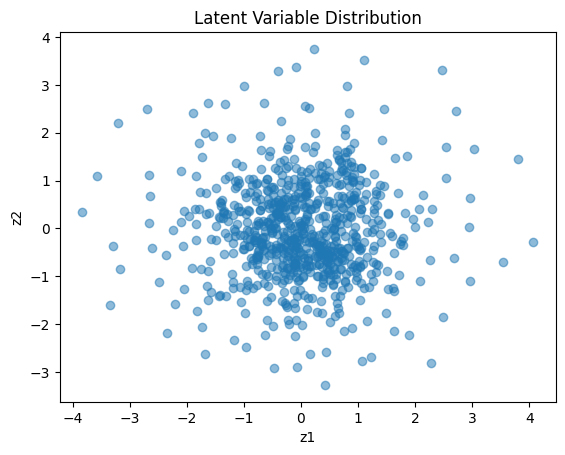

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def visualize_latent_distribution(model, data_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    zs = []  # List to store the latent variables

    with torch.no_grad():  # No need to track gradients
        for batch in data_loader:
            # Handle DataLoader returning either (data, target) or just data
            x = batch[0] if isinstance(batch, list) or isinstance(batch, tuple) else batch
            x = x.to(device, dtype=torch.float32)
            if x.dim() > 2:  # If your data is in a higher dimensional shape (e.g., images)
                x = x.view(x.size(0), -1)  # Flatten the image
            # Ensure the flattened size matches the model's expected input size
            assert x.shape[1] == input_size, f"Input shape must be [batch_size, {input_size}], but got: {x.shape}"
            mu, sigma = model.encode(x)
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon  # Reparameterization trick
            zs.append(z.cpu().numpy())  # Move z to CPU and convert to numpy

    zs = np.concatenate(zs, axis=0)  # Combine all batch zs into a single array

    if zs.shape[1] == 2:  # Check if the latent space is 2D
        plt.scatter(zs[:, 0], zs[:, 1], alpha=0.5)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('Latent Variable Distribution')
        plt.show()
    else:
        print("Latent space is not 2D. Consider using dimensionality reduction for visualization.")
        print(zs.shape[1])

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 100  # Replace 200 with the actual size of your input data

# Assuming 'train_data' is defined and is a PyTorch Dataset
# Make sure your DataLoader is correctly set up to load the dataset
data_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
visualize_latent_distribution(model, data_loader, device)


Generate Data

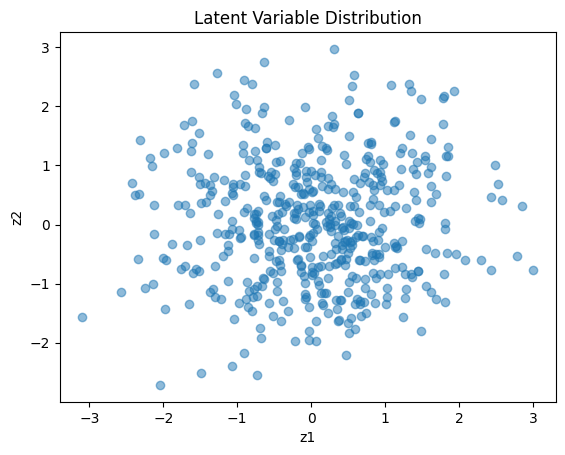

In [40]:
def generate(num_examples=1, mu_vals=None, sigma_vals=None, save_path='./output.mat'):
    if mu_vals is None:
        mu_vals = [0] * 2
        #mu_vals = [-0.16, -0.3]
        #mu_vals = [random.uniform(-0.2, 0.2) for _ in range(4)]
    if sigma_vals is None:
        sigma_vals = [1] * 2

    generated_data = []
    zs = []
    # print(generated_data, mu_vals)
    mu = torch.tensor(mu_vals, dtype=torch.float).to(DEVICE)
    sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE)
    
    for i in range(num_examples):
        epsilon = torch.randn_like(sigma)
        #mu = torch.tensor([random.uniform(-5, 5) for _ in range(4)], dtype=torch.float).to(DEVICE)
        z = mu + sigma * epsilon
        # print(z.shape)
        z = z.view(1,2)
        out = model.decode(z)
        out = out.view(1, 1, INPUT_DIM)  # Adjusted output shape
        # print(out[0,0,0])
        #out = out * 10
        generated_data.append(out)
        zs.append(z)
        #print(z)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0).cpu().detach().numpy()

    # Save the generated data as a .mat file
    scipy.io.savemat(save_path, {'generated_data': generated_data})
    #print(np.where(generated_data<0))
    #return generated_data

    #Plot distribution of z
    zs = np.concatenate(zs, axis=0)
    if zs.shape[1] == 2:  # Check if the latent space is 2D
        plt.scatter(zs[:, 0], zs[:, 1], alpha=0.5)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('Latent Variable Distribution')
        plt.show()

generated_data = generate(num_examples=500, save_path='./output_theta+bias1.mat')

In [12]:
generated_data = generate(num_examples=100, save_path='./output_theta+bias1.mat')

In [9]:
print(generated_data[3])

[[0.00028411 0.05234737 0.04797823 0.04421415 0.03875498 0.01685215
  0.01082624 0.00700575 0.00516035 0.00547098 0.0045221  0.00370633
  0.00293047 0.00328738 0.00263979 0.00260783 0.00348331 0.02302855
  0.00629312 0.01178335 0.02040565 0.03818487 0.03711201 0.06087416
  0.07577338 0.09416895 0.11786502 0.14083138 0.1523429  0.171155
  0.16865888 0.16298683 0.14780536 0.12432418 0.10674155 0.09144424
  0.08055209 0.06582782 0.06402303 0.05156618 0.04606368 0.02077344
  0.01460921 0.01360699 0.00796333 0.00585255 0.00961805 0.00581539
  0.00365641 0.00240115 0.00342594 0.00401294 0.00554766 0.00584399
  0.00355556 0.00966443 0.01126921 0.01291591 0.0140652  0.02361258
  0.00945819 0.03063254 0.0414787  0.05529776 0.05703026 0.06242647
  0.0706693  0.07064448 0.08104251 0.08231163 0.0867929  0.08468538
  0.08395071 0.08254439 0.08604357 0.09220032 0.09170415 0.10367917
  0.09659114 0.09717874 0.09545883 0.09291275 0.09042667 0.08649794
  0.08403222 0.08290898 0.07554255 0.07063833 0.06

## SoftIntroVAE

Import Training Data

In [ ]:
#with h5py.File('./VAE/preprocessed2.mat', 'r') as mat_file:

#with h5py.File('./VAE/preprocessed_normalized.mat', 'r') as mat_file:
with h5py.File('./preprocessed(theta_ma+bias,1iteration).mat', 'r') as mat_file:
    # Access the 'bc_dict' group
    bc_dict_group = mat_file['bc_dict']

    # Initialize a 3D NumPy array to store theta
    conformalWeldings = np.empty((len(bc_dict_group), 1, 100), dtype=np.float32)  # Use float32 instead of complex128

    # Iterate over the fields (e.g., 'Case00_12', 'Case00_13', etc.)
    for i, field_name in enumerate(bc_dict_group):
        case_group = bc_dict_group[field_name]
        xq = case_group['x'][:]  # Load the 'x' dataset into a structured array
        yq = case_group['y'][:]  # Load the 'y' dataset into a structured array
        theta = case_group['theta'][:]  # Load the 'theta' dataset into a structured array
        theta = np.insert(theta, 0, 0)
        theta = np.diff(theta) # Use diff between theta to train
        theta_ma = case_group['theta_ma'][:]  # Load the 'theta_ma' dataset into a structured array
        theta_ma = np.insert(theta_ma, 0, 0)
        theta_ma = np.diff(theta_ma)
        bias = case_group['bias'][:]  # Load the 'bias' dataset into a structured array
        
        conformalWeldings[i, :, :100] = theta # Correspond theta and bias together
        #conformalWeldings[i, :, -100:] = bias 


conformalWeldings = torch.tensor(conformalWeldings).to(DEVICE) 

# Create a DataLoader for your dataset
train_data = TensorDataset(conformalWeldings)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

Configuration

In [ ]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 1000
Z_DIM = 2
NUM_EPOCHS = 30000
BATCH_SIZE = 128 # Adjusted batch size
LR_RATE = 1e-4
dim_scale = 1/INPUT_DIM
beta_kl = 0.3
beta_neg = 0.9
beta_rec = 0.2
gamma_r = 1e-8

# Assuming you have a PyTorch model called VariationalAutoEncoder defined in 'model.py'
model = VariationalAutoEncoder(input_dim=INPUT_DIM, h_dim=H_DIM, z_dim=Z_DIM).to(DEVICE)
optimizer_e = optim.Adam(model.parameters(), lr=LR_RATE)
optimizer_d = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.MSELoss(reduction="sum")

In [ ]:
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    total_lossE = 0  # To store encoder losses
    total_lossD = 0  # To store decoder losses
    total_loss_real_rec = 0  # To store total real reconstruction loss
    total_loss_real_kl = 0  # To store total real KL divergence loss

    for i, (real_batch,) in loop:
        real_batch = real_batch.to(DEVICE, dtype=torch.float32).view(real_batch.shape[0], INPUT_DIM)

        # =========== Update E ================
        for param_group in [model.img_2hid.parameters(), model.hid_2mu.parameters(), model.hid_2sigma.parameters()]:
            for param in param_group:
                param.requires_grad = True
        for param_group in [model.z_2hid.parameters(), model.hid_2img.parameters()]:
            for param in param_group:
                param.requires_grad = False

        x_reconstructed, real_mu, real_sigma = model(real_batch)
        rec_rec, rec_mu, rec_sigma = model(x_reconstructed)

        loss_real_rec = loss_fn(real_batch, x_reconstructed)
        loss_real_kl = -torch.sum(1 + torch.log(real_sigma.pow(2)) - real_mu.pow(2) - real_sigma.pow(2))

        noise = torch.randn(real_batch.size(0), Z_DIM).to(DEVICE)
        fake = model.decode(noise)
        fake_reconstructed, fake_mu, fake_sigma = model(fake)

        loss_fake_rec = loss_fn(fake, fake_reconstructed)
        loss_rec_rec = loss_fn(x_reconstructed, rec_rec)
        loss_fake_kl = -torch.sum(1 + torch.log(fake_sigma.pow(2)) - fake_mu.pow(2) - fake_sigma.pow(2))
        loss_rec_kl = -torch.sum(1 + torch.log(rec_sigma.pow(2)) - rec_mu.pow(2) - rec_sigma.pow(2))

        # expELBO
        exp_elbo_fake = (-2 * dim_scale * (beta_rec * loss_fake_rec + beta_neg * loss_fake_kl)).exp().mean()
        exp_elbo_rec = (-2 * dim_scale * (beta_rec * loss_rec_rec + beta_neg * loss_rec_kl)).exp().mean()
            
        # total loss
        lossE = dim_scale * (beta_kl * loss_real_kl + beta_rec * loss_real_rec) + 0.25 * (exp_elbo_fake + exp_elbo_rec)

        optimizer_e.zero_grad()
        lossE.backward()
        optimizer_e.step()

        total_lossE += lossE.item()

        # ========= Update D ==================
        for param_group in [model.img_2hid.parameters(), model.hid_2mu.parameters(), model.hid_2sigma.parameters()]:
            for param in param_group:
                param.requires_grad = False
        for param_group in [model.z_2hid.parameters(), model.hid_2img.parameters()]:
            for param in param_group:
                param.requires_grad = True

        # Generate fake and handle decoder update similarly to the encoder part, focusing on decoder's losses
        # Note: Adjust the calculations for decoder's loss here
        x_reconstructed, real_mu, real_sigma = model(real_batch)
        rec_rec, rec_mu, rec_sigma = model(x_reconstructed)

        loss_real_rec = loss_fn(real_batch, x_reconstructed)
        loss_real_kl = -torch.sum(1 + torch.log(real_sigma.pow(2)) - real_mu.pow(2) - real_sigma.pow(2))

        noise = torch.randn(real_batch.size(0), Z_DIM).to(DEVICE)
        fake = model.decode(noise)
        fake_reconstructed, fake_mu, fake_sigma = model(fake)

        loss_fake_rec = loss_fn(fake, fake_reconstructed)
        loss_rec_rec = loss_fn(x_reconstructed, rec_rec)
        loss_fake_kl = -torch.sum(1 + torch.log(fake_sigma.pow(2)) - fake_mu.pow(2) - fake_sigma.pow(2))
        loss_rec_kl = -torch.sum(1 + torch.log(rec_sigma.pow(2)) - rec_mu.pow(2) - rec_sigma.pow(2))

        lossD = beta_rec * loss_real_rec + 0.5 * beta_kl * (loss_fake_kl + loss_rec_kl) + \
                            gamma_r * 0.5 * beta_rec * (loss_rec_rec + loss_fake_rec)
        lossD = dim_scale * lossD

        optimizer_d.zero_grad()
        lossD.backward()
        optimizer_d.step()

        total_lossD += lossD.item()
        total_loss_real_rec += loss_real_rec.item()
        total_loss_real_kl += loss_real_kl.item()

        loop.set_postfix(lossE=total_lossE / (i+1), lossD=total_lossD / (i+1))

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Avg Encoder Loss: {total_lossE / len(train_loader):.4f}, Avg Decoder Loss: {total_lossD / len(train_loader):.4f}")
        print(f"Average Real Reconstruction Loss: {total_loss_real_rec/ len(train_loader):.4f}, Average Real KL Divergence: {total_loss_real_kl/ len(train_loader):.4f}")

save model

In [ ]:
model = model.to("cpu")

In [ ]:
torch.save(model, './SoftIntro-VAE_theta+bias1.pth')

Generate data

In [ ]:
def generate(num_examples=1, mu_vals=None, sigma_vals=None, save_path='./output.mat'):
    if mu_vals is None:
        mu_vals = [0] * 2
        #mu_vals = [-0.16, -0.3]
        #mu_vals = [random.uniform(-0.2, 0.2) for _ in range(4)]
    if sigma_vals is None:
        sigma_vals = [1] * 2

    generated_data = []
    mu = torch.tensor(mu_vals, dtype=torch.float).to(DEVICE)
    sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE)
    
    for i in range(num_examples):
        epsilon = torch.randn_like(sigma)
        #mu = torch.tensor([random.uniform(-5, 5) for _ in range(4)], dtype=torch.float).to(DEVICE)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(1, 1, INPUT_DIM)  # Adjusted output shape
        #out = out * 10
        generated_data.append(out)
        #print(z)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0).cpu().detach().numpy()

    # Save the generated data as a .mat file
    scipy.io.savemat(save_path, {'generated_data': generated_data})

generate(num_examples=100, save_path='./SoftIntro_output_theta+bias1.mat')

## SoftIntroVAE 2

In [ ]:
# imports for the tutorial
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### Helper functions

In [ ]:
"""
Helper Functions
"""
def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

def load_model(model, pretrained):
    weights = torch.load(pretrained)
    pretrained_dict = weights['model']
    model.load_state_dict(pretrained_dict)
    model_dict = model.state_dict()
    

def save_checkpoint(model, epoch, iteration, prefix=""):
    model_out_path = "./saves/" + prefix + "model_epoch_{}_iter_{}.pth".format(epoch, iteration)
    state = {"epoch": epoch, "model": model.state_dict()}
    if not os.path.exists("./saves/"):
        os.makedirs("./saves/")

    torch.save(state, model_out_path)

    print("model checkpoint saved @ {}".format(model_out_path))


def setup_grid(range_lim=4, n_pts=1000, device=torch.device("cpu")):
    x = torch.linspace(-range_lim, range_lim, n_pts)
    xx, yy = torch.meshgrid((x, x))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    return xx, yy, zz.to(device)


def format_ax(ax, range_lim):
    ax.set_xlim(-range_lim, range_lim)
    ax.set_ylim(-range_lim, range_lim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    
    
def plot_vae_density(model, ax, test_grid, n_pts, batch_size, colorbar=False, beta_kl=1.0,
                     beta_recon=1.0, set_title=True, device=torch.device('cpu')):
    """ plots square grid and vae density """
    model.eval()
    xx, yy, zz = test_grid
    # compute posterior approx density
    # p(x) = E_{z~p(z)}[q(z|x)]
    zzk = []
    with torch.no_grad():
        for zz_i in zz.split(batch_size, dim=0):
                zz_i = zz_i.to(device)
                mu, logvar, _, rec = model(zz_i, deterministic=True)
                recon_error = calc_reconstruction_loss(zz_i, rec, loss_type='mse', reduction='none')
                while len(recon_error.shape) > 1:
                    recon_error = recon_error.sum(-1)
                kl = calc_kl(logvar=logvar, mu=mu, reduce="none")
                zzk_i = -1.0 * (beta_kl * kl + beta_recon * recon_error)
                zzk += [zzk_i.exp()]
    p_x = torch.cat(zzk, 0)
    # plot
    cmesh = ax.pcolormesh(xx.data.cpu().numpy(), yy.data.cpu().numpy(), p_x.view(n_pts, n_pts).data.cpu().numpy(),
                          cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    if set_title:
        ax.set_title('VAE density')
    if colorbar:
        plt.colorbar(cmesh)
        
        
def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce", "gaussian"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    recon_x = recon_x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def calc_kl(logvar, mu, mu_o=10, is_outlier=False, reduce='sum'):
    """
    Calculate kl-divergence
    :param logvar: log-variance from the encoder
    :param mu: mean from the encoder
    :param mu_o: negative mean for outliers (hyper-parameter)
    :param is_outlier: if True, calculates with mu_neg
    :param reduce: type of reduce: 'sum', 'none'
    :return: kld
    """
    if is_outlier:
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp() + 2 * mu * mu_o - mu_o.pow(2)).sum(1)
    else:
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl


def plot_samples_density(dataset, model, scale, device):
    """
    Plot real data from dataset, generated samples from model and density estimation
    """
    model.eval()
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    plot_batch = dataset.next_batch(batch_size=1024, device=device)
    plot_batch = plot_batch.data.cpu().numpy()
    ax1.scatter(plot_batch[:, 0], plot_batch[:, 1], s=8, label="true dist")
    ax1.set_xlim((-scale * 2, scale * 2))
    ax1.set_ylim((-scale * 2, scale * 2))
    ax1.set_axis_off()
    ax1.set_title('Real Data')
     
    ax2 = fig.add_subplot(1, 3, 2)
    noise_batch = torch.randn(size=(1024, model.zdim)).to(device)
    plot_fake_batch = model.sample(noise_batch)
    plot_fake_batch = plot_fake_batch.data.cpu().numpy()
    ax2.scatter(plot_fake_batch[:, 0], plot_fake_batch[:, 1], s=8, c='g', label="fake")
    ax2.set_xlim((-scale * 2, scale * 2))
    ax2.set_ylim((-scale * 2, scale * 2))
    ax2.set_axis_off()
    ax2.set_title('Fake Samples')
    
    ax3 = fig.add_subplot(1, 3, 3)
    test_grid = setup_grid(range_lim=scale * 2, n_pts=1024, device=torch.device('cpu'))
    plot_vae_density(model, ax3, test_grid, n_pts=1024, batch_size=256, colorbar=False,
                     beta_kl=1.0, beta_recon=1.0, set_title=False, device=device)
    ax3.set_axis_off()
    ax3.set_title("Density Estimation")
    return fig

### SoftIntroVAE Architecture

In [ ]:
"""
Models
"""

class EncoderSimple(nn.Module):
    def __init__(self, x_dim=200, zdim=2, n_layers=2, num_hidden=64):
        super(EncoderSimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden
        self.main = nn.Sequential()
        self.main.add_module('input', nn.Linear(x_dim, num_hidden))
        self.main.add_module('act0', nn.ReLU(True))
        for i in range(n_layers):
            self.main.add_module('hidden_%d' % (i + 1), nn.Linear(num_hidden, num_hidden))
            self.main.add_module('act_%d' % (i + 1), nn.ReLU(True))
        self.main.add_module('output', nn.Linear(num_hidden, zdim * 2))

    def forward(self, x):
        y = self.main(x).view(x.size(0), -1)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar


class DecoderSimple(nn.Module):
    def __init__(self, x_dim=200, zdim=2, n_layers=2, num_hidden=64):
        super(DecoderSimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden
        self.loggamma = nn.Parameter(torch.tensor(0.0))
        self.main = nn.Sequential()

        self.main.add_module('input', nn.Linear(zdim, num_hidden))
        self.main.add_module('act0', nn.ReLU(True))
        for i in range(n_layers):
            self.main.add_module('hidden_%d' % (i + 1), nn.Linear(num_hidden, num_hidden))
            self.main.add_module('act_%d' % (i + 1), nn.ReLU(True))
        self.main.add_module('output', nn.Linear(num_hidden, x_dim))

    def forward(self, z):
        z = z.view(z.size(0), -1)
        return self.main(z)


class SoftIntroVAESimple(nn.Module):
    def __init__(self, x_dim=200, zdim=2, n_layers=2, num_hidden=64):
        super(SoftIntroVAESimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden

        self.encoder = EncoderSimple(x_dim, zdim, n_layers, num_hidden)

        self.decoder = DecoderSimple(x_dim, zdim, n_layers, num_hidden)

    def forward(self, x, deterministic=False):
        mu, logvar = self.encode(x)
        if deterministic:
            z = mu
        else:
            z = reparameterize(mu, logvar)
        y = self.decode(z)
        return mu, logvar, z, y

    def sample(self, z):
        y = self.decode(z)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu")):
        z = torch.randn(num_samples, self.zdim).to(device)
        return self.decode(z)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z):
        y = self.decoder(z)
        return y

### Loading Data

In [ ]:
#with h5py.File('./VAE/preprocessed2.mat', 'r') as mat_file:

#with h5py.File('./VAE/preprocessed_normalized.mat', 'r') as mat_file:
with h5py.File('./preprocessed(theta_ma+bias,1iteration).mat', 'r') as mat_file:
    # Access the 'bc_dict' group
    bc_dict_group = mat_file['bc_dict']

    # Initialize a 3D NumPy array to store theta
    conformalWeldings = np.empty((len(bc_dict_group), 1, 200), dtype=np.float32)  # Use float32 instead of complex128

    # Iterate over the fields (e.g., 'Case00_12', 'Case00_13', etc.)
    for i, field_name in enumerate(bc_dict_group):
        case_group = bc_dict_group[field_name]
        xq = case_group['x'][:]  # Load the 'x' dataset into a structured array
        yq = case_group['y'][:]  # Load the 'y' dataset into a structured array
        theta = case_group['theta'][:]  # Load the 'theta' dataset into a structured array
        theta = np.insert(theta, 0, 0)
        theta = np.diff(theta) # Use diff between theta to train
        theta_ma = case_group['theta_ma'][:]  # Load the 'theta_ma' dataset into a structured array
        theta_ma = np.insert(theta_ma, 0, 0)
        theta_ma = np.diff(theta_ma)
        bias = case_group['bias'][:]  # Load the 'bias' dataset into a structured array
        
        conformalWeldings[i, :, :100] = theta # Correspond theta and bias together
        conformalWeldings[i, :, -100:] = bias 


#conformalWeldings = torch.tensor(conformalWeldings).to(DEVICE) 

# Create a DataLoader for your dataset
#train_data = TensorDataset(conformalWeldings)
#train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

### Training

In [ ]:
def train_soft_intro_vae_toy(z_dim=2, lr_e=2e-4, lr_d=2e-4, batch_size=32, n_iter=30000, num_vae=0, 
                             save_interval=1, recon_loss_type="mse", beta_kl=1.0, beta_rec=1.0,
                             beta_neg=1.0, test_iter=5000, seed=-1, pretrained=None, scale=1,
                             device=torch.device("cpu"), gamma_r=1e-8):
    if seed != -1:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        print("random seed: ", seed)

    # --------------build models -------------------------
    train_set = conformalWeldings
    #scale *= train_set.range  # the scale of the 2d grid ([-1, 1] for Gaussians, [-2, 2] for the rest)

    model = SoftIntroVAESimple(x_dim=200, zdim=z_dim, n_layers=3, num_hidden=256).to(device)
    if pretrained is not None:
        load_model(model, pretrained)
    print(model)

    optimizer_e = optim.Adam(model.encoder.parameters(), lr=lr_e)
    optimizer_d = optim.Adam(model.decoder.parameters(), lr=lr_d)

    milestones = (10000, 15000)
    e_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=milestones, gamma=0.1)
    d_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=milestones, gamma=0.1)

    start_time = time.time()
    dim_scale = 0.005  # normalizing factor, 's' in the paper

    for it in range(n_iter):
        batch = train_set.next_batch(batch_size=batch_size, device=device)
        # save models
        if it % save_interval == 0 and it > 0:
            save_epoch = (it // save_interval) * save_interval
            save_checkpoint(model, save_epoch, it, '')

        model.train()
        # --------------train----------------
        if it < num_vae:
            # vanilla VAE training, optimizeing the ELBO for both encoder and decoder
            batch_size = batch.size(0)

            real_batch = batch.to(device)

            # =========== Update E, D ================
            real_mu, real_logvar, z, rec = model(real_batch)

            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            loss_kl = calc_kl(real_logvar, real_mu, reduce="mean")
            loss = beta_rec * loss_rec + beta_kl * loss_kl

            optimizer_e.zero_grad()
            optimizer_d.zero_grad()
            loss.backward()
            optimizer_e.step()
            optimizer_d.step()

            if it % test_iter == 0:
                info = "\nIter: {}/{} : time: {:4.4f}: ".format(it, n_iter, time.time() - start_time)
                info += 'Rec: {:.4f}, KL: {:.4f} '.format(loss_rec.data.cpu(), loss_kl.data.cpu())
                print(info)
        else:
            # soft-intro-vae training
            if len(batch.size()) == 3:
                batch = batch.unsqueeze(0)

            b_size = batch.size(0)

            # generate random noise to produce 'fake' later
            noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
            real_batch = batch.to(device)

            # =========== Update E ================
            for param in model.encoder.parameters():
                param.requires_grad = True
            for param in model.decoder.parameters():
                param.requires_grad = False

            # generate 'fake' data
            fake = model.sample(noise_batch)
            # optimize for real data
            real_mu, real_logvar = model.encode(real_batch)
            z = reparameterize(real_mu, real_logvar)
            rec = model.decoder(z)  # reconstruction
            # we also want to see what is the reconstruction error from mu
            _, _, _, rec_det = model(real_batch, deterministic=True)

            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            # reconstruction error from mu (not optimized, only to observe)
            loss_rec_det = calc_reconstruction_loss(real_batch, rec_det.detach(), loss_type=recon_loss_type,
                                                    reduction="mean")

            # KLD loss for the real data
            lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

            # prepare the fake data for the expELBO
            fake_mu, fake_logvar, z_fake, rec_fake = model(fake.detach())
            # we also consider the reconstructions as 'fake' data, as they are output of the decoder
            rec_mu, rec_logvar, z_rec, rec_rec = model(rec.detach())
            
            # KLD loss for the fake data
            fake_kl_e = calc_kl(fake_logvar, fake_mu, reduce="none")
            rec_kl_e = calc_kl(rec_logvar, rec_mu, reduce="none")
            
            # reconstruction loss for the fake data
            loss_fake_rec = calc_reconstruction_loss(fake, rec_fake, loss_type=recon_loss_type, reduction="none")
            loss_rec_rec = calc_reconstruction_loss(rec, rec_rec, loss_type=recon_loss_type, reduction="none")
            
            # expELBO
            exp_elbo_fake = (-2 * dim_scale * (beta_rec * loss_fake_rec + beta_neg * fake_kl_e)).exp().mean()
            exp_elbo_rec = (-2 * dim_scale * (beta_rec * loss_rec_rec + beta_neg * rec_kl_e)).exp().mean()
            
            # total loss
            lossE = dim_scale * (beta_kl * lossE_real_kl + beta_rec * loss_rec) + 0.25 * (exp_elbo_fake + exp_elbo_rec)
            
            optimizer_e.zero_grad()
            lossE.backward()
            optimizer_e.step()

            # ========= Update D ==================
            for param in model.encoder.parameters():
                param.requires_grad = False
            for param in model.decoder.parameters():
                param.requires_grad = True

            # generate fake
            fake = model.sample(noise_batch)
            rec = model.decoder(z.detach())
            # ELBO loss for real -- just the reconstruction, KLD for real doesn't affect the decoder
            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            
            # prepare fake data for ELBO
            rec_mu, rec_logvar = model.encode(rec)
            z_rec = reparameterize(rec_mu, rec_logvar)
            
            fake_mu, fake_logvar = model.encode(fake)
            z_fake = reparameterize(fake_mu, fake_logvar)

            rec_rec = model.decode(z_rec.detach())
            rec_fake = model.decode(z_fake.detach())

            loss_rec_rec = calc_reconstruction_loss(rec.detach(), rec_rec, loss_type=recon_loss_type, reduction="mean")
            loss_rec_fake = calc_reconstruction_loss(fake.detach(), rec_fake, loss_type=recon_loss_type, reduction="mean")

            fake_kl = calc_kl(fake_logvar, fake_mu, reduce="mean")
            rec_kl = calc_kl(rec_logvar, rec_mu, reduce="mean")

            lossD = beta_rec * loss_rec + 0.5 * beta_kl * (fake_kl + rec_kl) + \
                            gamma_r * 0.5 * beta_rec * (loss_rec_rec + loss_rec_fake)
            lossD = dim_scale * lossD

            optimizer_d.zero_grad()
            lossD.backward()
            optimizer_d.step()
            
            if it % test_iter == 0:
                info = "\nIter: {}/{} : time: {:4.4f}: ".format(it, n_iter, time.time() - start_time)

                info += 'Rec: {:.4f} ({:.4f}), '.format(loss_rec.data.cpu(), loss_rec_det.data.cpu())
                info += 'Kl_E: {:.4f}, expELBO_R: {:.4f}, expELBO_F: {:.4f}, '.format(lossE_real_kl.data.cpu(),
                                                                                exp_elbo_rec.data.cpu(),
                                                                                exp_elbo_fake.cpu())
                info += 'Kl_F: {:.4f}, KL_R: {:.4f},'.format(fake_kl.data.cpu(), rec_kl.data.cpu())
                info += ' DIFF_Kl_F: {:.4f}'.format(-lossE_real_kl.data.cpu() + fake_kl.data.cpu())

                print(info)

            if torch.isnan(lossE) or torch.isnan(lossD):
                plt.close('all')
                raise SystemError("loss is NaN.")
        e_scheduler.step()
        d_scheduler.step()


    return model

In [ ]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
seed = 92  # for reproducible results
'''
chosen_hyperparmas = {'8Gaussians': {'b_kl': 0.3, 'b_neg': 0.9, 'b_rec': 0.2},
                      '2spirals': {'b_kl': 0.5, 'b_neg': 1.0, 'b_rec': 0.2},
                      'checkerboard': {'b_kl': 0.1, 'b_neg': 0.2, 'b_rec': 0.2},
                      'rings': {'b_kl': 0.2, 'b_neg': 1.0, 'b_rec': 0.2}}
'''
num_iter = 30000
lr = 2e-4
batch_size = 64

In [ ]:
model = train_soft_intro_vae_toy(z_dim=2, lr_e=lr, lr_d=lr, batch_size=batch_size, n_iter=num_iter, num_vae=2000, 
                             save_interval=5000, recon_loss_type="mse", beta_kl=0.2, beta_rec=0.2,
                             beta_neg=0.9, test_iter=5000, seed=seed, scale=1,
                             device=device)